In [1]:
pip install tensorflow

In [2]:
from google.colab import drive
import os
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers
from keras import models

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Menentukan base path, train path, dan test path di Google Drive
base_path = '/content/drive/MyDrive/Bangkit-Capstone-CH2-PS132/dataset_dl'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

In [5]:
#Image size VGG19
img_size = (224, 224)

In [7]:
# Data augmentation training dataset
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Rescaling test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

# Loading training dataset
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Loading validation dataset
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_images = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


In [8]:
# Load pre-trained VGG16 model tanpa top (fully connected) layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers VGG16
for layer in vgg16_base.layers:
    layer.trainable = False


# Buat model baru pada layer top VGG19
model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train model
history = model.fit(train_generator, epochs=20, validation_data=val_generator,callbacks=[early_stopping])

Epoch 1/50
58/58 [==============================] - 1675s 29s/step - loss: 1.9035 - accuracy: 0.3596 - val_loss: 1.2404 - val_accuracy: 0.6370
Epoch 2/50
58/58 [==============================] - 1575s 27s/step - loss: 1.1652 - accuracy: 0.6143 - val_loss: 0.9755 - val_accuracy: 0.6978
Epoch 3/50
58/58 [==============================] - 1543s 27s/step - loss: 0.9497 - accuracy: 0.6806 - val_loss: 0.8619 - val_accuracy: 0.7217
Epoch 4/50
58/58 [==============================] - 1499s 26s/step - loss: 0.8088 - accuracy: 0.7414 - val_loss: 0.8069 - val_accuracy: 0.7326
Epoch 5/50
58/58 [==============================] - 1532s 26s/step - loss: 0.7545 - accuracy: 0.7561 - val_loss: 0.7700 - val_accuracy: 0.7478
Epoch 6/50
55/58 [===========================>..] - ETA: 1:02 - loss: 0.6415 - accuracy: 0.7920

In [ ]:
model.save('/content/drive/MyDrive/Bangkit-Capstone-CH2-PS132/dl_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt

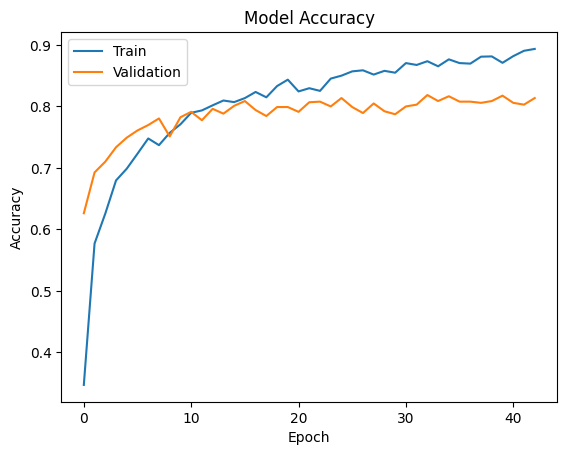

In [ ]:
# Plot training dan validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

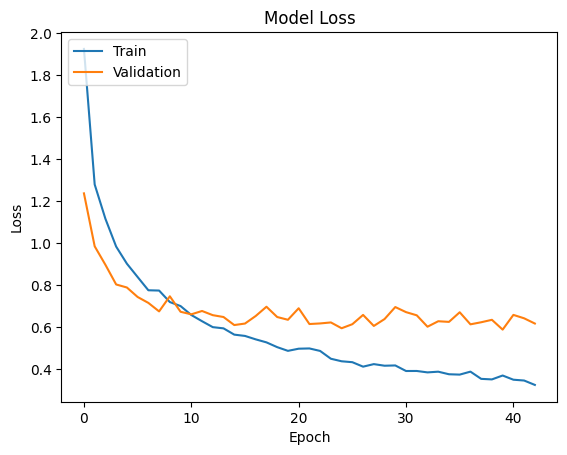

In [ ]:
# Plot training dan validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
from keras.preprocessing import image
import numpy as np
from keras.models import load_model

# Load saved model
model = load_model('/content/drive/MyDrive/Bangkit-Capstone-CH2-PS132/dl_model.h5')

# Load CSV file
csv_file_path = '/content/drive/MyDrive/Bangkit-Capstone-CH2-PS132/calorie_baru.csv'
df = pd.read_csv(csv_file_path)

# Fungsi prediksi kalori dari gambar yang diberikan
def predict_calories(image_path):
    # Load dan preprocess gambar
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # prediksi
    prediction = model.predict(img_array)

    # Ambil class
    predicted_class = np.argmax(prediction)


    predicted_class_str = df['category'].unique()[predicted_class]

    print("Predicted Class:", predicted_class_str)

    # Mencari baris yang memiliki kategori sama pada CSV file
    corresponding_row = df.iloc[predicted_class]

    # Check apakah baris kosong
    if not corresponding_row.empty:
        # Extract the calories value
        calories = corresponding_row['calorie']
        return calories
    else:
        # Handle jika row tidak ditemuka
        print("No matching row found in the CSV file for the predicted class.")
        return None  # or return a default value

# Contoh:
user_image_path = '/content/drive/MyDrive/Bangkit-Capstone-CH2-PS132/mango.jpg'
predicted_calories = predict_calories(user_image_path)

print(f"Predicted Calories: {predicted_calories}")

1/1 [==============================] - 1s 773ms/step
Predicted Class: kiwi
Predicted Calories: 46.0


In [ ]:
model.evaluate(test_images)

Unique Classes in CSV File: ['watermelon' 'strawberries' 'pineapple' 'orange' 'mango' 'kiwi' 'cherry'
 'banana' 'avocado' 'apple']
Unique Classes in Training Data: ['cherry', 'strawberries', 'banana', 'watermelon', 'mango', 'avocado', 'apple', 'orange', 'kiwi', 'pineapple']
